# <center> 14MBID .- Trabajo de Fin de Master <center>
## <center> Desarrollo de un modelo predictivo en base a sintomatología de salud mental que derivan en ansiedad y depresión <center>
###   <center> (Segunda Parte .- Análisis Exploratorio y Evaluación de Modelos 2020) <center>
###   <center> (Enfermedad: Depresión) <center>
### <center> Autor: Ricardo Marrero Carrión <center>

### Indice
<ol>
<li>Librerias a Utilizar y Comprobaciones Iniciales</li>
<li>Funciones del modelo</li>
<li>Introducción</li>
<li>Carga de los Datasets</li>
<li>Análisis Exploratorio</li>
<li>Minería de Datos</li>
</ol>

### 1.- Librerías a Utilizar y comprobaciones iniciales

In [1]:
#Librerías de uso general
from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

# Funcionalidades de scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.svm import NuSVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Carga de funciones adicionales
%reload_ext autoreload
%autoreload 2
import analisis_modelos as pf
import inspect
from IPython.display import Markdown, display

# Método de balanceo de clases
from imblearn.over_sampling import SMOTE

#Deshabilitar mensajes de advertencia al usuario
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

#Constantes
rmst = 123
crossval = 5

In [2]:
inicio = datetime.now()
print("Fecha y hora de inicio =", inicio)

Fecha y hora de inicio = 2022-09-28 13:51:04.716965


### 2.- Funciones del Modelo

Las funciones utilizadas en el modelo, son importadas de un fichero .py llamado analisis_modelos.py

### 3.- Introducción

Una vez finalizada las fases de Limpieza de Datos, Transformaciones y Selecciones de Variables Significativas, se procede a realizar el análisis exploratorio de los conjuntos de datos resultantes y al evaluación de los algoritmos de Machine Learning, para seleccionar el modelo óptimo que busca el Dominio de este proceso. Haciendo un estudio individual para la Ansiedad y la Depresión.

Debido a que el conjunto de datos posee las etiquetas o clases que queremos clasificar, se analizarán varios métodos de Aprendizaje Supervisado. Y como referencia a estudios previos, se tomarán de base los ya utilizados por Arkaprabha Saua e Ishita Bhakta, publicado en su artículo [Screening of anxiety and depression among seafarers using machine learning technology](https://doi.org/10.1016/j.imu.2019.100228).

Los algoritmos de clasificación a analizar en este TFM son:

* __Modelos lineales:__ Regresión Logística y Stochastic Gradient Descent - SGD.
* __Modelos de Combinación de métodos (ensembles):__ Random Forest, Extra Trees, Xgboost y Catboost.
* __Modelo de Arbol de Decisión.__
* __Modelo de Support Vector Machine (SVM).__
* __Modelo basado en el algoritmo de Naive Bayes.__

Para la evaluación de los algoritmos, y su posterior comparativa y selección final, se hará uso de las siguientes métricas:

* __Matriz de confusión:__ para medir el rendimiento del modelo en las predicciones de las clases (depresión y ansiedad).
* __Precisión (Accuracy):__ porcentaje total de valores correctamente clasificados.
* __Recall (Sensibilidad) :__ porcentaje valores positivos son correctamente clasificados.
* __Area bajo la curva (AUC):__ relación entre 0 -1 del porcentaje del ratio de prediccción de verdaderos positivos vs. falsos positivos.

Una vez seleccionados los **tres mejores modelos** que ofrecen las mejores métricas, teniendo en cuenta el dominio; se construirá un clasificador que junte los estimadores y resultados individuales, en un solo modelo.

**IMPORTANTE:** Por la extensión del código utilizado, para ilustrar de una forma más clara los pasos ejecutados, se ejecutarán dos Notebook por separado. Uno para la detección de la *Ansiedad* y otro para la detección de la *Depresión.*

### 4.- Carga de los Datasets

In [3]:
#Carga de los conjuntos de datos salida de la fase de selección de variables y análisis de correlaciones

#Depresion
conjunto_datos = pd.read_csv('depresion2020_modelo.csv',index_col= 1)
conjunto_datos = conjunto_datos.drop('Unnamed: 0',axis=1)

### 5.- Análisis Exploratorio

Para proceder a esta fase, se debe recordar el objetivo del TFM, que es buscar patrones en la detección de la Ansiedad y la Depresión.

Estamos ante un problema de *Clasificación de una Clase Conocida* que tiene *dos posibles estados*: no tiene la enfermedad, o si la tiene.

Así que se deben analizar modelos y algoritmos orientados a __Clasificación de Etiquetas Binarias.__

Otro punto a tomar en cuenta en esta fase, es la tendencia de las variables objetivos. Debido a la naturaleza de la encuesta utilizada, y las respuestas ofrecidas por los entrevistados, __tanto la Clase Ansiedad como la Clase Depresión están ampliamente desbalanceadas.__

#### 5.1- Mapeo de las variables objetivos

Los valores actuales de la clase objetivo son:
* 1.- SI tiene la enfermedad.
* 2.- NO tiene la enfermedad.

Al estar en un problema de variables binarias, se cambian dichos valores a:
* 0.- NO tiene la enfermedad.
* 1.- SI tiene la enfermedad.

In [4]:
conjunto_datos['depresion'] = np.where((conjunto_datos['depresion'] == 2),0,1)

In [5]:
# Durante la evaluación de los modelos se encontró que las variables de la enfermedad a 12 meses, introducían
# ruido al modelo, se proceden a eliminar
drop_col = ['depresion_12meses']
conjunto_datos = conjunto_datos.drop(drop_col,axis=1)

In [6]:
# Reset a los índices para evitar errores en la validación cruzada durante la fase de Minería de Datos
conjunto_datos.reset_index(drop = True, inplace = True)

#### 5.2- Balanceo de clases

Para resolver el problema del desbalanceo de la clase objetivo, se ejecutará un *Oversampling* de la clase minoritaria, en este caso "SI tiene la enfermedad". Esta técnica consiste en añadir ejemplos a dicha condición.

Usaremos el algoritmo __SMOTE__, que mediante un sobremuestreo estadístico, añade nuevas instancias a la clase minoritaria, para igualar la cantidad de SI y NO en el conjunto de entrenamiento y test.

Es importante tomar en cuenta que a partir de este momento, el conjunto de datos generados, es el que se debe usar en las siguientes fases.

In [7]:
X = conjunto_datos.drop('depresion', axis=1)
y = conjunto_datos.depresion

In [8]:
print(y.value_counts())

0    19957
1     2115
Name: depresion, dtype: int64


In [9]:
# Técnica de Over-sampling basada en SMOTE
smote = SMOTE(sampling_strategy ='auto' , random_state = rmst)
X_sampling, y_sampling = smote.fit_resample(X, y)

In [10]:
print(y_sampling.value_counts())

0    19957
1    19957
Name: depresion, dtype: int64


Clase 0: 19957
Clase 1: 19957
Proportion: 1.0 : 1


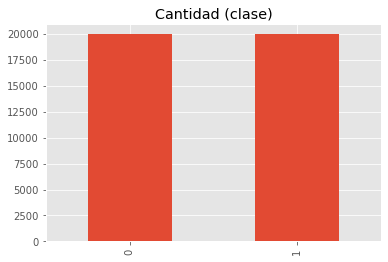

In [11]:
target_count = y_sampling.value_counts()
cero = target_count[0]
uno = target_count[1]
print('Clase 0:', cero)
print('Clase 1:', uno)
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Cantidad (clase)');

Así, se han creado 17.842 nuevas muestras en las instancias de la clase minoritaria (1) para balancear con la clase mayoritaria (2)

#### 5.3- Construcción de los conjuntos de entrenamiento y pruebas

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_sampling, y_sampling,
                                                    test_size=.20, 
                                                    random_state=rmst, 
                                                    stratify= y_sampling)

In [13]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(31931, 37)
(7983, 37)
(31931,)
(7983,)


Se observa que al haber aplicado el balanceo de clases mediante SMOTE, el conjunto de datos ha aumentado de 22072 instancias a 39914 instancias.

#### 5.4- Funciones de evaluación

Para la elaboración de las gráficas a utilizar en la vizualización de las métricas de cada algoritmo, se ha utilizado una herramienta desarrollada por Vivienne DiFrancesco, y disponible en el siguiente repositorio de GitHub: [project_functions](https://github.com/HeyThatsViv/Predicting-Depression.git)

In [14]:
# Classification report
func = inspect.getsource(pf.make_classification_report)

In [15]:
#Matriz de Confusión
func = inspect.getsource(pf.plot_confusion_matrix)

In [16]:
# Gráfico ROC (Area bajo la curva)
func = inspect.getsource(pf.plot_roc_curve)

In [17]:
# Variables significativas para los modelos de árbol
func = inspect.getsource(pf.plot_top_features)

In [18]:
# Constructor funciones de evaluación
func = inspect.getsource(pf.evaluate_model)

#### 5.5- Estudio de algoritmos de clasificación

A continuación se va a proceder a estudiar varios modelos de aprendizaje supervisado que pueden ser utilizados para la clasificación de variables binarias balanceadas.

Como se comentó en la primera parte, como estrategia se utilizarán los 5 modelos propuestos por Sausa y Bhakta en su estudio, y se añaden otros modelos que podrían tener buen rendimiento en problemas de clasificación.

Para cada clasificador se estudiarán dos modelos:

* Una versión base, con los estimadores por defecto que trae cada algoritmo.
* Una versión con análisis de parámetros basada en GridSearchCV (parrilla de parámetros con validación cruzada)

##### 5.5.1- Regresión Logística

In [19]:
# Clasificador Base
logreg_clf = LogisticRegressionCV(random_state=rmst,
                                  n_jobs=-1,
                                  cv = crossval
                                  )

# Entrenamiento
logreg_base = logreg_clf.fit(X_train, y_train)

__________________________________________________________________
Reporte para el Clasificador: 
	Regresión Logística CV
__________________________________________________________________


              precision    recall  f1-score   support

           0       0.79      0.82      0.80      3992
           1       0.81      0.78      0.79      3991

    accuracy                           0.80      7983
   macro avg       0.80      0.80      0.80      7983
weighted avg       0.80      0.80      0.80      7983

__________________________________________________________________


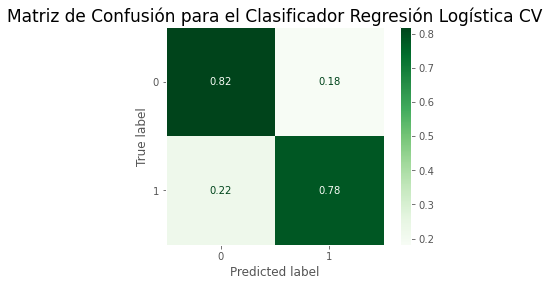

__________________________________________________________________


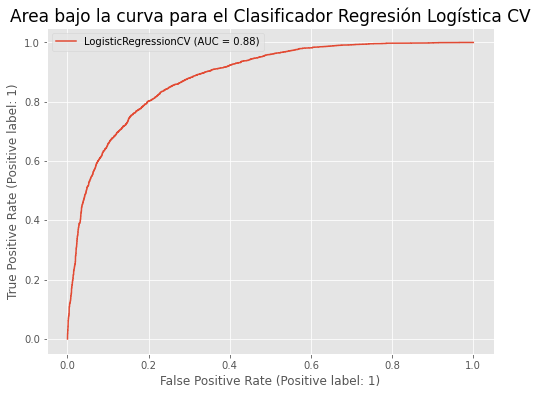

In [20]:
# Evaluación del modelo base
pf.evaluate_model(logreg_base, X_train, X_test, y_test, 
               title='Regresión Logística CV')

In [21]:
# Clasificador aplicando GridSearch CV
Cs_list = list(logreg_base.Cs_)
Cs_list

[0.0001,
 0.000774263682681127,
 0.005994842503189409,
 0.046415888336127774,
 0.3593813663804626,
 2.782559402207126,
 21.54434690031882,
 166.81005372000558,
 1291.5496650148827,
 10000.0]

In [22]:
# Estimadores a analizar
logreg_params = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
                 'C': Cs_list,
                 'penalty': ['l1', 'l2', 'elasticnet', 'none']
                }

# Clasificador Base
logreg_clf2 = LogisticRegression(random_state=rmst,
                                  n_jobs=-1,
                               )

# Evaluación y selección de estimadores
gridcv_logreg = GridSearchCV(logreg_clf2,
                    logreg_params, 
                    n_jobs=-1,
                    cv = crossval)

# Entrenamiento
logreg_grid = gridcv_logreg.fit(X_train, y_train)

In [23]:
# Mejores estimadores
logreg_grid.best_params_

{'C': 0.3593813663804626, 'penalty': 'l1', 'solver': 'saga'}

In [24]:
C_drill_list = list(np.linspace(logreg_grid.best_params_['C']/5, logreg_grid.best_params_['C']*5, 10))
C_drill_list.append(logreg_grid.best_params_['C'])
C_drill_list

[0.07187627327609251,
 0.26354633534567257,
 0.4552163974152526,
 0.6468864594848326,
 0.8385565215544126,
 1.0302265836239928,
 1.2218966456935727,
 1.4135667077631529,
 1.6052367698327328,
 1.796906831902313,
 0.3593813663804626]

In [25]:
# Estimadores a analizar
logreg_params = {'C': C_drill_list}

# Clasificador con los mejores estimadores
logreg_clf2 = LogisticRegression(solver='saga', 
                                random_state=rmst,
                                penalty = 'l1',
                                n_jobs=-1
                               )

# Evaluación y selección de estimadores
gridcv_logreg = GridSearchCV(logreg_clf2,
                             logreg_params,
                             n_jobs=-1,
                             cv = crossval)

# Entrenamiento
logreg_grid2 = gridcv_logreg.fit(X_train, y_train)

In [26]:
# Mejores estimadores
logreg_grid2.best_params_

{'C': 0.4552163974152526}

In [27]:
# Modelo Regresión logística con estimadores
logreg_gridmodel = logreg_grid2.best_estimator_
logreg_gridmodel

LogisticRegression(C=0.4552163974152526, n_jobs=-1, penalty='l1',
                   random_state=123, solver='saga')

__________________________________________________________________
Reporte para el Clasificador: 
	Regresión Logística con GridSearch CV
__________________________________________________________________


              precision    recall  f1-score   support

           0       0.79      0.82      0.80      3992
           1       0.81      0.78      0.79      3991

    accuracy                           0.80      7983
   macro avg       0.80      0.80      0.80      7983
weighted avg       0.80      0.80      0.80      7983

__________________________________________________________________


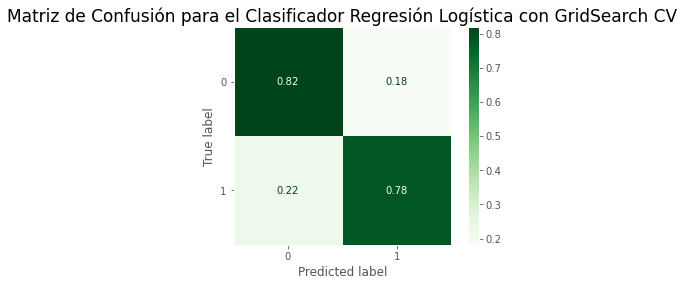

__________________________________________________________________


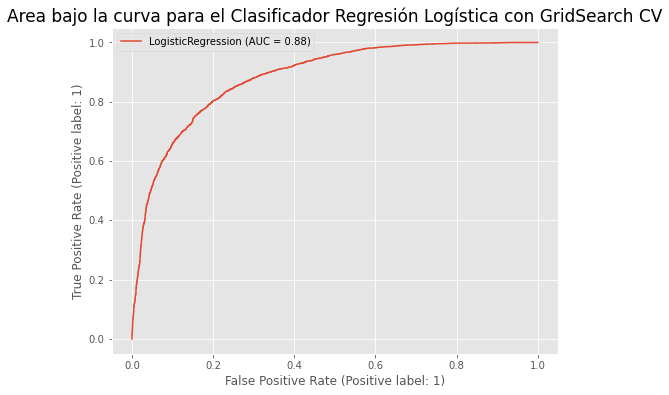

In [28]:
# Evaluación del modelo
pf.evaluate_model(logreg_gridmodel, X_train, X_test, y_test, 
               title='Regresión Logística con GridSearch CV')

##### 5.5.2- Arbol de Decisiones

In [29]:
# Clasificador Base
tree_clf = DecisionTreeClassifier(random_state=rmst)

# Entrenamiento
tree_base = tree_clf.fit(X_train, y_train)

__________________________________________________________________
Reporte para el Clasificador: 
	Arbol de Decisión
__________________________________________________________________


              precision    recall  f1-score   support

           0       0.93      0.92      0.92      3992
           1       0.92      0.93      0.92      3991

    accuracy                           0.92      7983
   macro avg       0.92      0.92      0.92      7983
weighted avg       0.92      0.92      0.92      7983

__________________________________________________________________


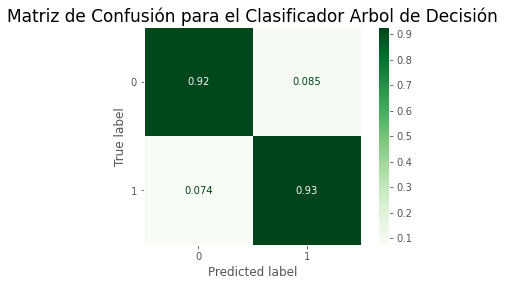

__________________________________________________________________


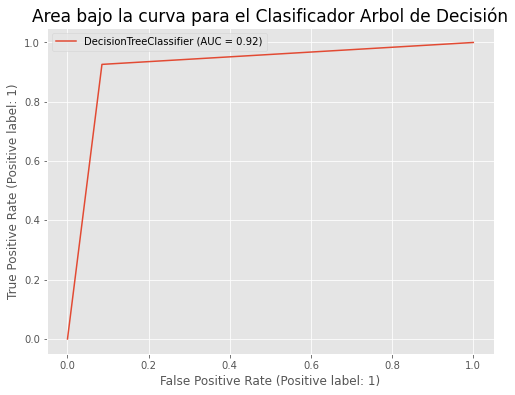

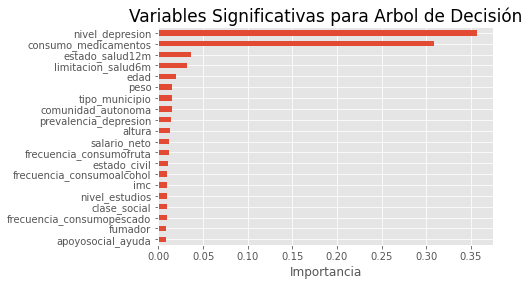

In [30]:
# Evaluación del modelo base
pf.evaluate_model(tree_base, X_train, X_test, y_test, 
               tree=True, title='Arbol de Decisión')

In [31]:
# Clasificador aplicando GridSearch CV
# Estimadores a analizar
tree_params = {'max_features': ['auto', 'sqrt', 'log2'],
               'ccp_alpha': [0.1, .01, .001],
               'max_depth' : [5, 6, 7, 8, 9],
               'criterion' :['gini', 'entropy', 'log_loss']
              }

# Clasificador Base
tree_clf2 = DecisionTreeClassifier(random_state = rmst)

# Evaluación y selección de estimadores
gridcv_tree = GridSearchCV(tree_clf2,
                    tree_params,
                    n_jobs=-1,
                    cv = crossval)

# Entrenamiento
tree_grid = gridcv_tree.fit(X_train, y_train)

In [32]:
# Mejores estimadores
tree_grid.best_params_

{'ccp_alpha': 0.001,
 'criterion': 'entropy',
 'max_depth': 9,
 'max_features': 'auto'}

In [33]:
# Estimadores a analizar
tree_params = {'ccp_alpha': [0.1, .01, .001],
               'max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, 9],
              }

# Clasificador con los mejores estimadores
tree_clf2 = DecisionTreeClassifier(random_state = rmst,
                                   criterion='gini',
                                   max_features= 'auto')

# Evaluación y selección de estimadores
gridcv_tree = GridSearchCV(tree_clf2,
                           tree_params,
                           n_jobs=-1,
                           cv = crossval)

# Entrenamiento
tree_grid2 = gridcv_tree.fit(X_train, y_train)

In [34]:
# Mejores estimadores
tree_grid2.best_params_

{'ccp_alpha': 0.001, 'max_depth': 9}

In [35]:
# Modelo Arbol de Desición con estimadores
tree_gridmodel = tree_grid2.best_estimator_
tree_gridmodel

DecisionTreeClassifier(ccp_alpha=0.001, max_depth=9, max_features='auto',
                       random_state=123)

__________________________________________________________________
Reporte para el Clasificador: 
	Arbol de Decisión con GridSearchCV
__________________________________________________________________


              precision    recall  f1-score   support

           0       0.86      0.82      0.84      3992
           1       0.83      0.87      0.85      3991

    accuracy                           0.84      7983
   macro avg       0.84      0.84      0.84      7983
weighted avg       0.84      0.84      0.84      7983

__________________________________________________________________


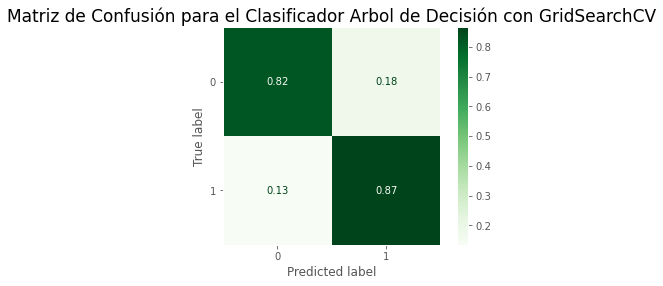

__________________________________________________________________


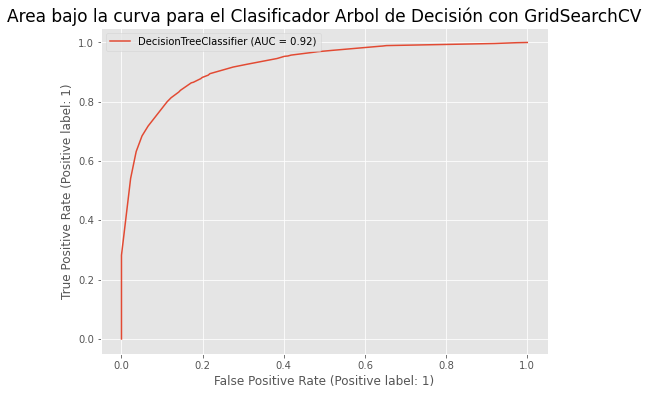

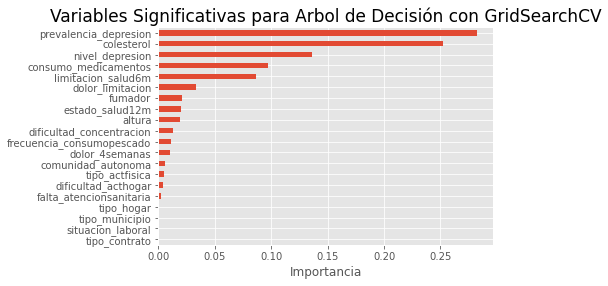

In [36]:
# Evaluación del modelo
pf.evaluate_model(tree_gridmodel, X_train, X_test, y_test, 
               tree=True, title='Arbol de Decisión con GridSearchCV')

##### 5.5.3- Support Vector Machine (SVM)

In [37]:
# Clasificador Base
svm_clf = NuSVC(random_state = rmst)

# Entrenamiento
svm_base = svm_clf.fit(X_train, y_train)

__________________________________________________________________
Reporte para el Clasificador: 
	Support Vector Machine
__________________________________________________________________


              precision    recall  f1-score   support

           0       0.80      0.85      0.83      3992
           1       0.84      0.79      0.82      3991

    accuracy                           0.82      7983
   macro avg       0.82      0.82      0.82      7983
weighted avg       0.82      0.82      0.82      7983

__________________________________________________________________


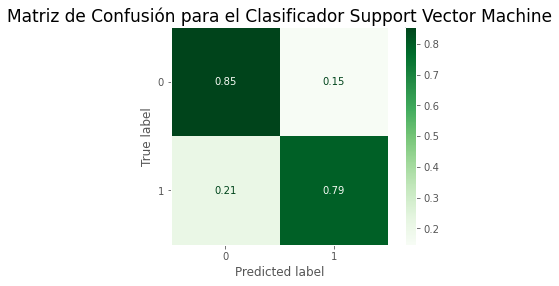

__________________________________________________________________


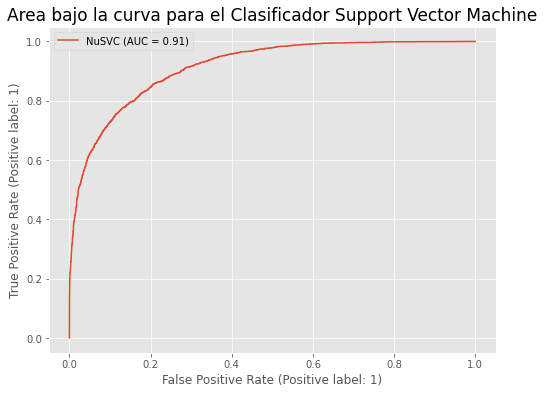

In [38]:
# Evaluación del modelo base
pf.evaluate_model(svm_base, X_train, X_test, y_test, 
               title='Support Vector Machine')

In [39]:
# Clasificador aplicando GridSearch CV
# Estimadores a analizar
svm_params = {'nu': [0,.25,.5,.75,1], 
              'kernel': ['linear','rbf','sigmoid']
             }

# Clasificador Base
svm_clf2 = NuSVC(random_state = rmst)

# Evaluación y selección de estimadores
grid_svm = GridSearchCV(svm_clf2,
                    svm_params,
                    n_jobs=-1,
                    cv = crossval)

# Entrenamiento
svm_grid = grid_svm.fit(X_train, y_train)

In [40]:
# Mejores estimadores
svm_grid.best_params_

{'kernel': 'rbf', 'nu': 0.25}

In [41]:
# Estimadores a analizar
svm_params = {'nu': [0,.125,.25]}

# Clasificador con los mejores estimadores
svm_clf2 = NuSVC(random_state = rmst,
                 kernel= 'rbf')

# Evaluación y selección de estimadores
grid_svm = GridSearchCV(svm_clf2,
                    svm_params,
                    n_jobs=-1,
                    cv = crossval)

# Entrenamiento
svm_grid2 = grid_svm.fit(X_train, y_train)

In [42]:
# Mejores estimadores
svm_grid2.best_params_

{'nu': 0.125}

In [43]:
# Modelo SVM con estimadores
svm_gridmodel = svm_grid2.best_estimator_
svm_gridmodel

NuSVC(nu=0.125, random_state=123)

__________________________________________________________________
Reporte para el Clasificador: 
	Support Vector Machine con GridSearchCV
__________________________________________________________________


              precision    recall  f1-score   support

           0       0.99      0.94      0.96      3992
           1       0.94      0.99      0.97      3991

    accuracy                           0.96      7983
   macro avg       0.97      0.96      0.96      7983
weighted avg       0.97      0.96      0.96      7983

__________________________________________________________________


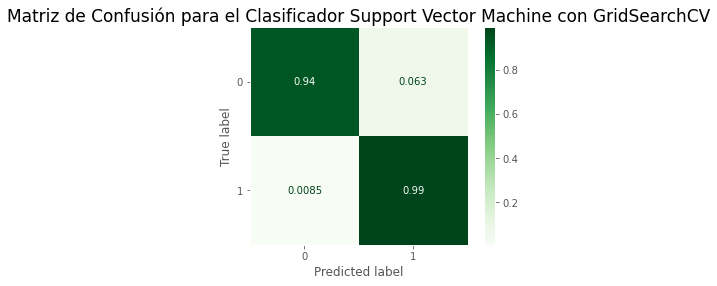

__________________________________________________________________


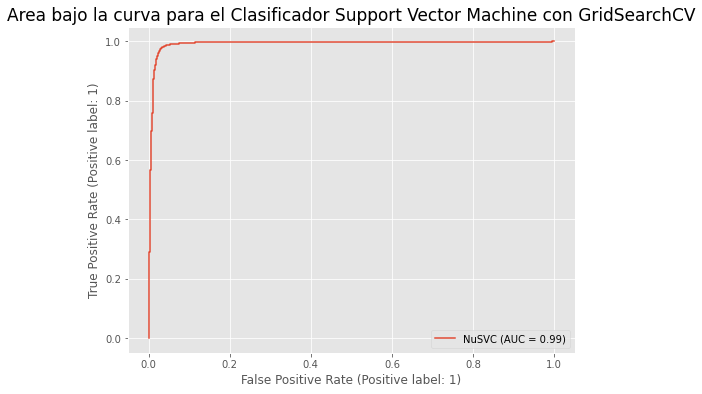

In [44]:
# Evaluación del modelo
pf.evaluate_model(svm_gridmodel, X_train, X_test, y_test, 
                  title='Support Vector Machine con GridSearchCV')

##### 5.5.4- Naive Bayes

In [45]:
# Clasificador Base
gnb_clf = GaussianNB()

# Entrenamiento
nb_base = gnb_clf.fit(X_train, y_train)

__________________________________________________________________
Reporte para el Clasificador: 
	Naive Bayes
__________________________________________________________________


              precision    recall  f1-score   support

           0       0.76      0.79      0.77      3992
           1       0.78      0.74      0.76      3991

    accuracy                           0.77      7983
   macro avg       0.77      0.77      0.77      7983
weighted avg       0.77      0.77      0.77      7983

__________________________________________________________________


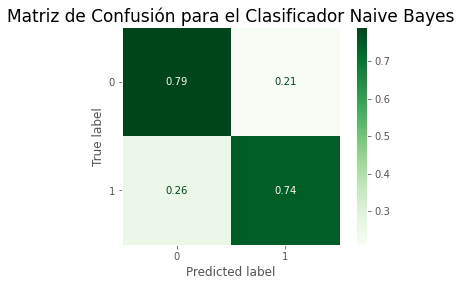

__________________________________________________________________


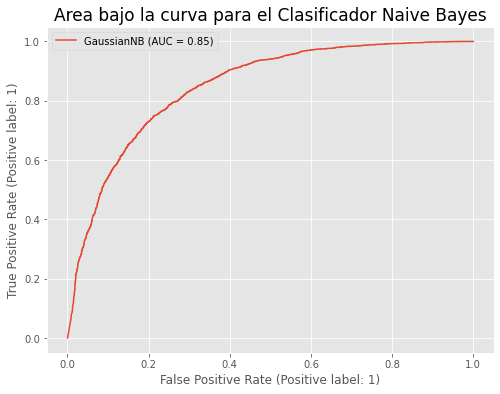

In [46]:
# Evaluación del modelo base
pf.evaluate_model(nb_base, X_train, X_test, y_test, 
               title='Naive Bayes')

In [47]:
# Clasificador aplicando GridSearch CV
# Estimadores a analizar
nb_params = {}

# Clasificador Base
gnb_clf2 = GaussianNB()

# Evaluación y selección de estimadores
grid_nb = GridSearchCV(gnb_clf,
                     nb_params,
                     cv = crossval,
                     scoring='f1_micro',
                     verbose=1,
                     n_jobs=-1)

# Entrenamiento
nb_grid2 = grid_nb.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [48]:
# Mejores estimadores
nb_grid2.best_params_

{}

In [49]:
# Modelo NB con estimadores
nb_gridmodel = nb_grid2.best_estimator_
nb_gridmodel

GaussianNB()

__________________________________________________________________
Reporte para el Clasificador: 
	Naive Bayes con GridSearch CV
__________________________________________________________________


              precision    recall  f1-score   support

           0       0.76      0.79      0.77      3992
           1       0.78      0.74      0.76      3991

    accuracy                           0.77      7983
   macro avg       0.77      0.77      0.77      7983
weighted avg       0.77      0.77      0.77      7983

__________________________________________________________________


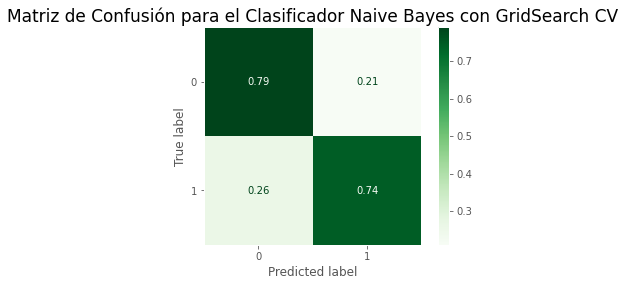

__________________________________________________________________


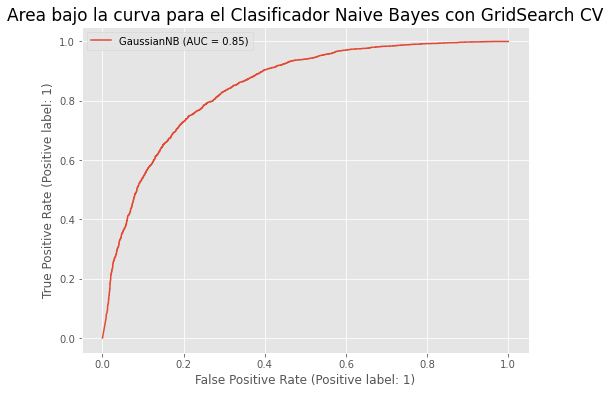

In [50]:
# Evaluación del modelo
pf.evaluate_model(nb_gridmodel, X_train, X_test, y_test, 
                  title='Naive Bayes con GridSearch CV')

##### 5.5.5- Stochastic Gradient Descent Linear Classifier (SGD)

In [51]:
# Clasificador Base
sgd_clf = SGDClassifier(random_state= rmst, n_jobs=-1)

# Entrenamiento
sgd_base = sgd_clf.fit(X_train, y_train)

__________________________________________________________________
Reporte para el Clasificador: 
	SGD
__________________________________________________________________


              precision    recall  f1-score   support

           0       0.83      0.74      0.78      3992
           1       0.77      0.85      0.81      3991

    accuracy                           0.80      7983
   macro avg       0.80      0.80      0.80      7983
weighted avg       0.80      0.80      0.80      7983

__________________________________________________________________


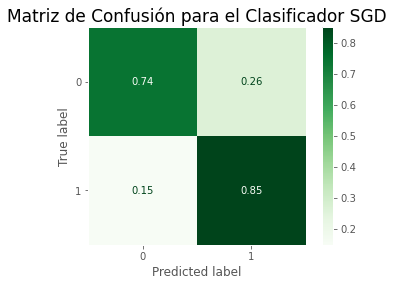

__________________________________________________________________


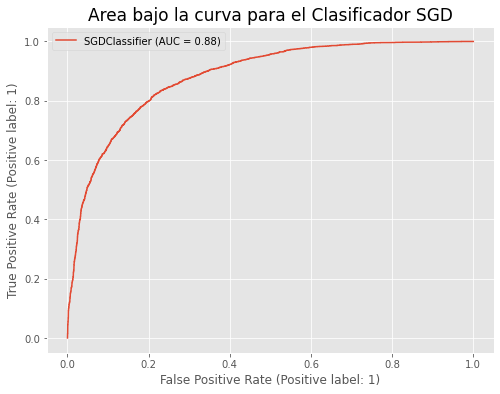

In [52]:
# Evaluación del modelo base
pf.evaluate_model(sgd_base, X_train, X_test, y_test, 
               title='SGD')

In [ ]:
# Clasificador aplicando GridSearch CV
# Estimadores a analizar
sgd_params = {'loss': ['hinge', 'log_loss', 'log', 'modified_huber', 'squared_hinge', 'perceptron',
                       'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'], 
              'penalty': ['l2', 'l1', 'elasticnet'],
              'fit_intercept': [True, False], 
              'alpha': [.01, .001, .0001, .00001]}

# Clasificador Base
sgd_clf2 = SGDClassifier(random_state=rmst, n_jobs=-1)

# Evaluación y selección de estimadores
grid_sgd = GridSearchCV(sgd_clf2,
                        sgd_params,
                        n_jobs=-1,
                        cv = crossval)

# Entrenamiento
sgd_grid = grid_sgd.fit(X_train, y_train)

In [54]:
# Mejores estimadores
sgd_grid.best_params_

{'alpha': 0.001, 'fit_intercept': True, 'loss': 'log_loss', 'penalty': 'l1'}

In [55]:
# Estimadores a analizar
sgd_params = {'alpha': [1, .5, .1, .05, .01, .005, .001]}

# Clasificador con los mejores estimadores
sgd_clf2 = SGDClassifier(random_state=rmst,
                        n_jobs=-1,
                        fit_intercept=True, 
                        loss='log_loss',
                        penalty='l2',
                        l1_ratio=.4)

# Evaluación y selección de estimadores
grid_sgd = GridSearchCV(sgd_clf2,
                        sgd_params,
                        n_jobs=-1,
                        cv= crossval)

# Entrenamiento
sgd_grid2 = grid_sgd.fit(X_train, y_train)

In [56]:
# Mejores estimadores
sgd_grid2.best_params_

{'alpha': 0.001}

In [57]:
# Modelo SGD con estimadores
sgd_grid_finalmodel = sgd_grid2.best_estimator_
sgd_grid_finalmodel

SGDClassifier(alpha=0.001, l1_ratio=0.4, loss='log_loss', n_jobs=-1,
              random_state=123)

__________________________________________________________________
Reporte para el Clasificador: 
	SGD con GridSearch CV
__________________________________________________________________


              precision    recall  f1-score   support

           0       0.81      0.78      0.80      3992
           1       0.79      0.82      0.81      3991

    accuracy                           0.80      7983
   macro avg       0.80      0.80      0.80      7983
weighted avg       0.80      0.80      0.80      7983

__________________________________________________________________


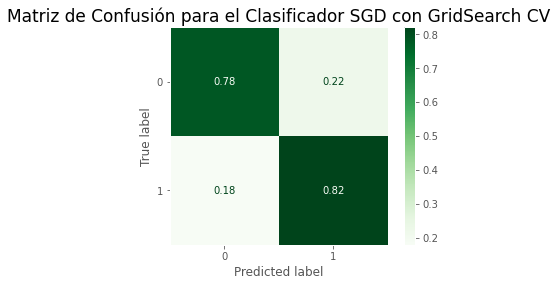

__________________________________________________________________


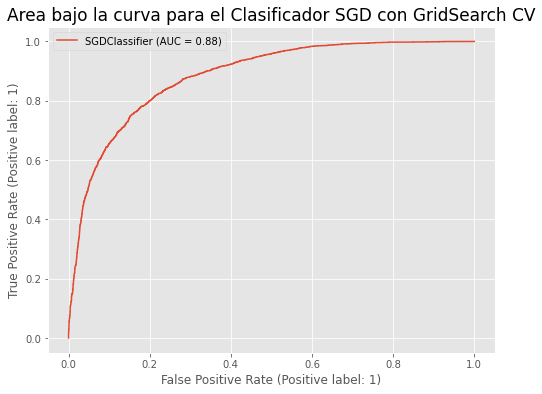

In [58]:
# Evaluación del modelo
pf.evaluate_model(sgd_grid_finalmodel, X_train, X_test, y_test, 
               title='SGD con GridSearch CV')

##### 5.5.6- Random Forest

In [59]:
# Clasificador Base
forest_clf = RandomForestClassifier(n_jobs=-1, 
                                    random_state=rmst)

# Entrenamiento
forest_base = forest_clf.fit(X_train, y_train)

__________________________________________________________________
Reporte para el Clasificador: 
	Random Forest
__________________________________________________________________


              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3992
           1       0.97      0.95      0.96      3991

    accuracy                           0.96      7983
   macro avg       0.96      0.96      0.96      7983
weighted avg       0.96      0.96      0.96      7983

__________________________________________________________________


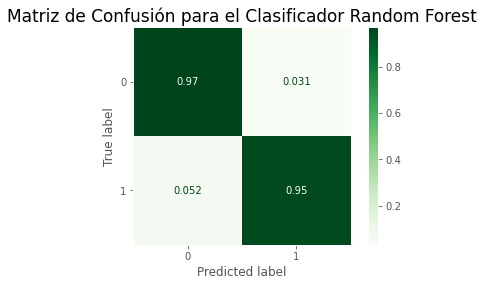

__________________________________________________________________


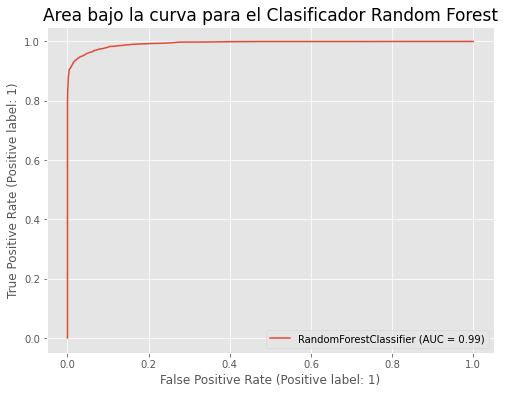

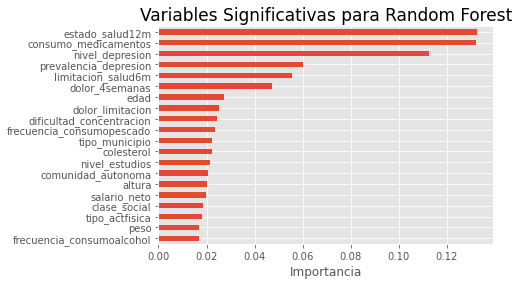

In [60]:
# Evaluación del modelo base
pf.evaluate_model(forest_base, X_train, X_test, y_test, 
               tree=True, title='Random Forest')

In [61]:
# Clasificador aplicando GridSearch CV
# Estimadores a analizar
forest_params = {'criterion': ['gini', 'entropy','log_loss'], 
                 'max_depth': [None, 5, 10, 20, 50], 
                 'min_samples_leaf': [1, 10, 20], 
                 'max_features': ['sqrt', 'log2', None],
                 'max_samples': [None, .5, .7, .9]
                }

# Clasificador Base
forest_clf2 = RandomForestClassifier(random_state=rmst)

# Evaluación y selección de estimadores
grid_forest = GridSearchCV(forest_clf2,
                           forest_params
                           ,n_jobs=-1,
                           cv= crossval)

# Entrenamiento
forest_grid = grid_forest.fit(X_train, y_train)

In [62]:
# Mejores estimadores
forest_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'log2',
 'max_samples': None,
 'min_samples_leaf': 1}

In [63]:
# Estimadores a analizar
forest_params = {}

# Clasificador con los mejores estimadores
forest_clf2 = RandomForestClassifier(random_state=rmst, 
                                    criterion='gini', 
                                    max_depth= None,
                                    max_features='sqrt',
                                    min_samples_leaf = 1,
                                    max_samples = None
                                   )

# Evaluación y selección de estimadores
grid_forest = GridSearchCV(forest_clf2,
                           forest_params,
                           n_jobs=-1,
                           cv= crossval)

# Entrenamiento
forest_grid2 = grid_forest.fit(X_train, y_train)

In [64]:
# Mejores estimadores
forest_grid2.best_params_

{}

In [65]:
# Modelo Random Forest con estimadores
forest_gridmodel = forest_grid2.best_estimator_
forest_gridmodel

RandomForestClassifier(random_state=123)

__________________________________________________________________
Reporte para el Clasificador: 
	Random Forest con GridSearch CV
__________________________________________________________________


              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3992
           1       0.97      0.95      0.96      3991

    accuracy                           0.96      7983
   macro avg       0.96      0.96      0.96      7983
weighted avg       0.96      0.96      0.96      7983

__________________________________________________________________


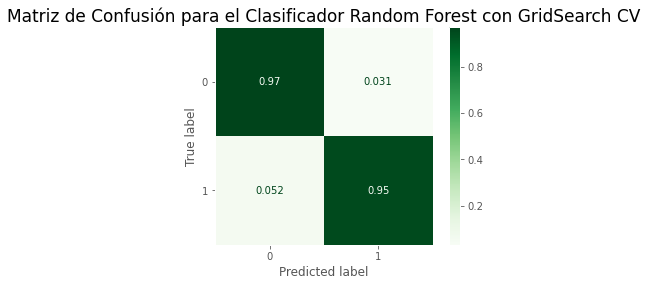

__________________________________________________________________


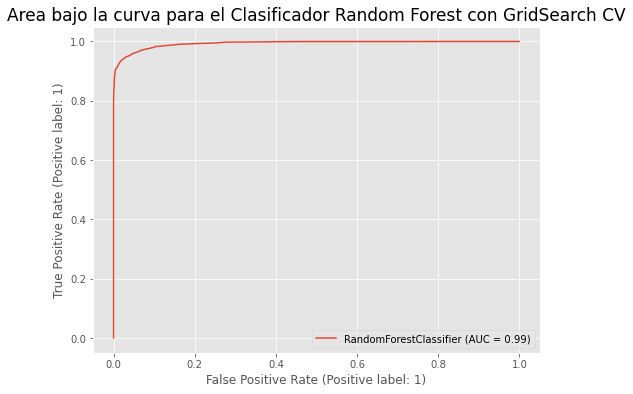

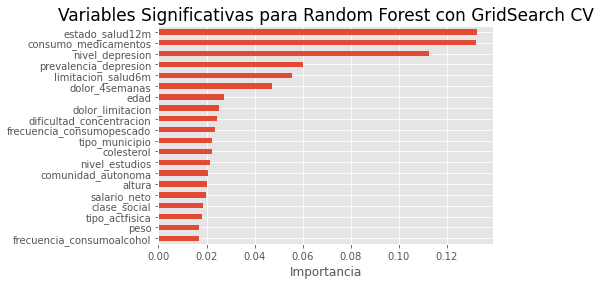

In [66]:
# Evaluación del modelo
pf.evaluate_model(forest_gridmodel, X_train, X_test, y_test, 
               tree=True, title='Random Forest con GridSearch CV')

##### 5.5.7- Extra Trees

In [67]:
# Clasificador Base
extratrees_clf = ExtraTreesClassifier(n_jobs=-1,
                                       random_state=rmst)


# Entrenamiento
extratrees_base = extratrees_clf.fit(X_train, y_train)

__________________________________________________________________
Reporte para el Clasificador: 
	Extra Trees
__________________________________________________________________


              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3992
           1       0.96      0.99      0.97      3991

    accuracy                           0.97      7983
   macro avg       0.98      0.97      0.97      7983
weighted avg       0.98      0.97      0.97      7983

__________________________________________________________________


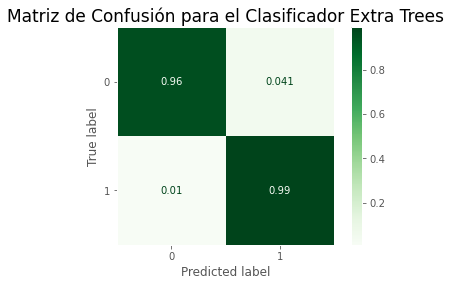

__________________________________________________________________


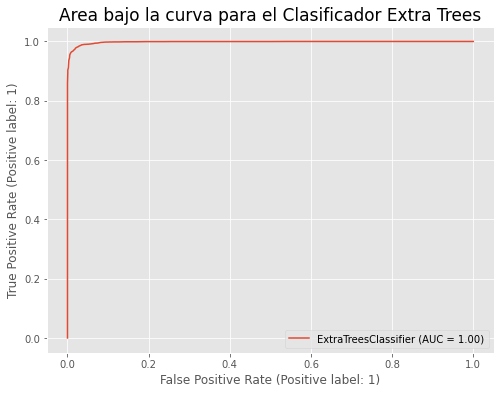

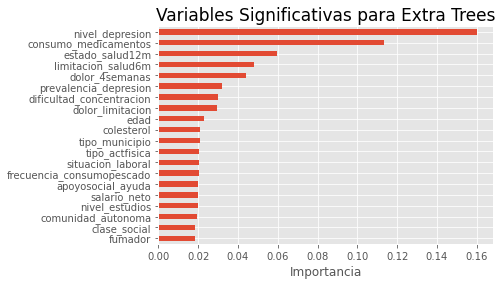

In [68]:
# Evaluación del modelo base
pf.evaluate_model(extratrees_base, X_train, X_test, y_test, 
               tree=True, title='Extra Trees')

In [69]:
# Clasificador aplicando GridSearch CV
# Estimadores a analizar
trees_params = {'criterion': ['gini', 'entropy','log_loss'], 
                'max_depth': [None, 10, 50], 
                'min_samples_leaf': [1, 5], 
                'max_features': ['sqrt','log2', None], 
                'bootstrap': [True, False], 
                'max_samples': [.5, .7, .9]
               }

# Clasificador Base
extratrees_clf2 = ExtraTreesClassifier(random_state=rmst)

# Evaluación y selección de estimadores
grid_extratree = GridSearchCV(extratrees_clf2,
                              trees_params,
                              n_jobs=-1,
                              cv= crossval)

# Entrenamiento
extratrees_grid = grid_extratree.fit(X_train, y_train)

In [70]:
# Mejores estimadores
extratrees_grid.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'max_samples': 0.9,
 'min_samples_leaf': 1}

In [71]:
# Estimadores a analizar
trees_params ={'max_depth': [5, 10, 20, 30, 40,50], 
               'max_samples': [.3, .4, .5, .6, .9]}

# Clasificador con los mejores estimadores
extratrees_clf2 = ExtraTreesClassifier(random_state=rmst, 
                                      criterion='entropy', 
                                      bootstrap=True, 
                                      max_features='sqrt',
                                      min_samples_leaf = 1
                                     )

# Evaluación y selección de estimadores
grid_extratree = GridSearchCV(extratrees_clf2,
                             trees_params,
                             n_jobs=-1,
                             cv= crossval)

# Entrenamiento
extratrees_grid2 = grid_extratree.fit(X_train, y_train)

In [72]:
# Mejores estimadores
extratrees_grid2.best_params_

{'max_depth': 40, 'max_samples': 0.9}

In [73]:
# Modelo Extra Trees con estimadores
extratrees_gridmodel = extratrees_grid2.best_estimator_
extratrees_gridmodel

ExtraTreesClassifier(bootstrap=True, criterion='entropy', max_depth=40,
                     max_samples=0.9, random_state=123)

__________________________________________________________________
Reporte para el Clasificador: 
	Extra Trees con GridSearch CV
__________________________________________________________________


              precision    recall  f1-score   support

           0       0.99      0.94      0.96      3992
           1       0.94      0.99      0.96      3991

    accuracy                           0.96      7983
   macro avg       0.96      0.96      0.96      7983
weighted avg       0.96      0.96      0.96      7983

__________________________________________________________________


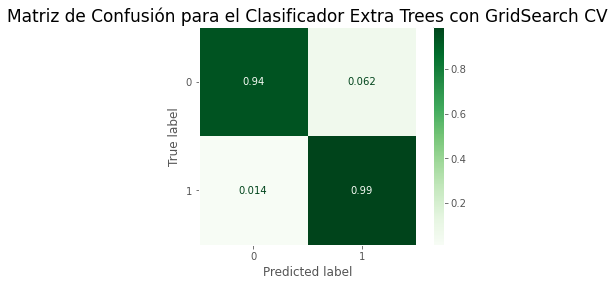

__________________________________________________________________


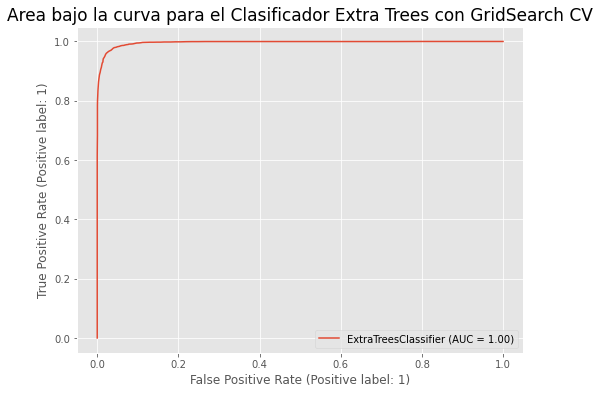

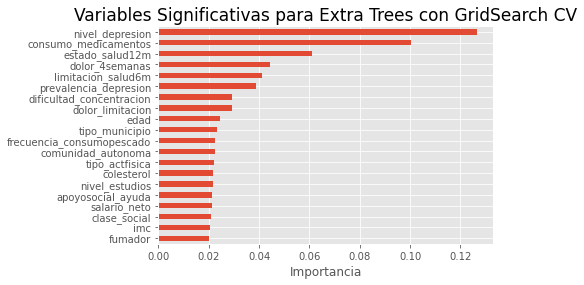

In [74]:
# Evaluación del modelo
pf.evaluate_model(extratrees_gridmodel, X_train, X_test, y_test, 
               tree=True, title='Extra Trees con GridSearch CV')

##### 5.5.8- XgBoost

In [75]:
# Clasificador Base
xgb_clf = XGBClassifier(seed = rmst)

# Entrenamiento
xgb_base = xgb_clf.fit(X_train, y_train)

__________________________________________________________________
Reporte para el Clasificador: 
	Xgboost
__________________________________________________________________


              precision    recall  f1-score   support

           0       0.93      0.96      0.95      3992
           1       0.96      0.93      0.95      3991

    accuracy                           0.95      7983
   macro avg       0.95      0.95      0.95      7983
weighted avg       0.95      0.95      0.95      7983

__________________________________________________________________


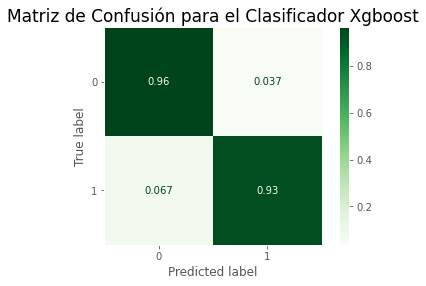

__________________________________________________________________


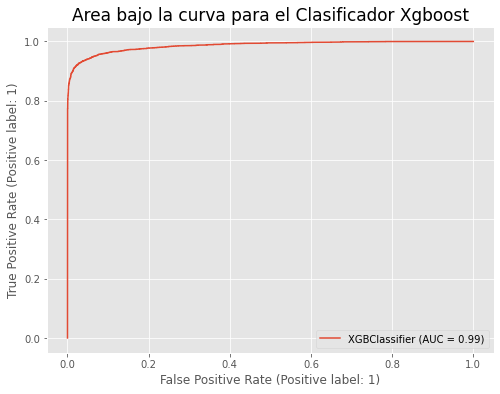

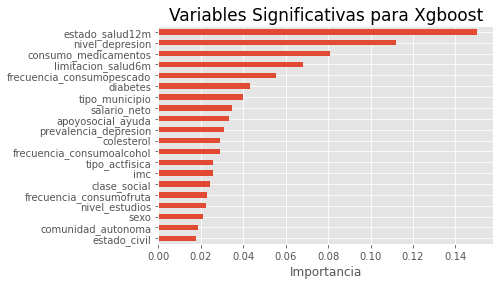

In [76]:
# Evaluación del modelo base
pf.evaluate_model(xgb_base, X_train, X_test, y_test, 
               title='Xgboost', tree=True)

In [77]:
# Clasificador aplicando GridSearch CV
# Estimadores a analizar
xgb_params = {'max_depth': [None, 3, 10], 
              'learning_rate': [.1, .05], 
              'min_child_weight': [1, 5, 10], 
              'subsample': [.3, .5, .7]
              }

# Clasificador Base
xgb_clf2 = XGBClassifier(n_jobs=-1, random_state=rmst)

# Evaluación y selección de estimadores
grid_xgb = GridSearchCV(xgb_clf2,
                        xgb_params,
                        n_jobs=-1,
                        cv= crossval)

# Entrenamiento
xgb_grid = grid_xgb.fit(X_train, y_train)

In [78]:
# Mejores estimadores
xgb_grid.best_params_

{'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 1,
 'subsample': 0.5}

In [79]:
# Estimadores a analizar
xgb_params = {'max_depth': [5, 10], 
              'learning_rate': [.1, .01, .03], 
              'subsample': [.2, .3, .7]
             }

# Clasificador con los mejores estimadores
xgb_clf2 = XGBClassifier(n_jobs=-1,
                          random_state=rmst,
                          min_child_weight=1)

# Evaluación y selección de estimadores
grid_xgb = GridSearchCV(xgb_clf2,
                        xgb_params,
                        n_jobs=-1,
                        cv= crossval)

# Entrenamiento
xgb_grid2 = grid_xgb.fit(X_train, y_train)

In [80]:
# Mejores estimadores
xgb_grid2.best_params_

{'learning_rate': 0.1, 'max_depth': 10, 'subsample': 0.3}

In [81]:
# Modelo XGboost con estimadores
xgb_gridmodel = xgb_grid2.best_estimator_
xgb_gridmodel

XGBClassifier(max_depth=10, n_jobs=-1, random_state=123, subsample=0.3)

__________________________________________________________________
Reporte para el Clasificador: 
	XgBoost con GridSearchCV
__________________________________________________________________


              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3992
           1       0.97      0.93      0.95      3991

    accuracy                           0.95      7983
   macro avg       0.96      0.95      0.95      7983
weighted avg       0.96      0.95      0.95      7983

__________________________________________________________________


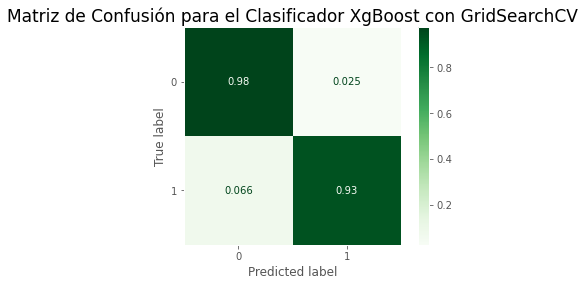

__________________________________________________________________


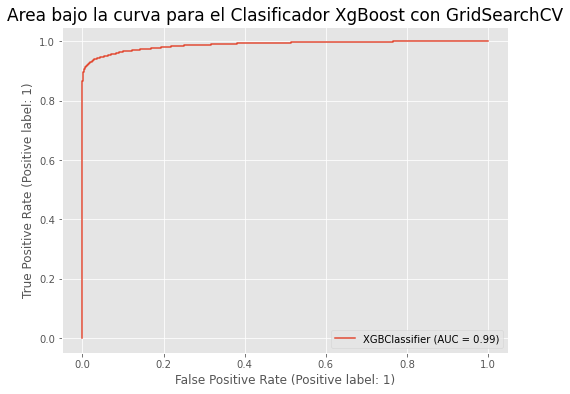

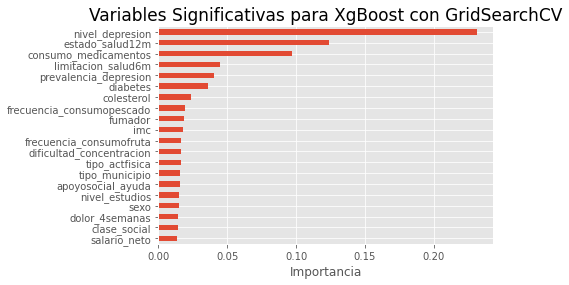

In [82]:
# Evaluación del modelo
pf.evaluate_model(xgb_gridmodel, X_train, X_test, y_test, 
               title='XgBoost con GridSearchCV', tree=True)

##### 5.5.9- CatBoost

In [83]:
# Clasificador Base
cat_clf = CatBoostClassifier(random_state = rmst,
                            verbose = False)

# Entrenamiento
cat_base = cat_clf.fit(X_train, y_train,early_stopping_rounds=3,verbose=False)

__________________________________________________________________
Reporte para el Clasificador: 
	Catboost
__________________________________________________________________


              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3992
           1       0.98      0.93      0.95      3991

    accuracy                           0.96      7983
   macro avg       0.96      0.96      0.96      7983
weighted avg       0.96      0.96      0.96      7983

__________________________________________________________________


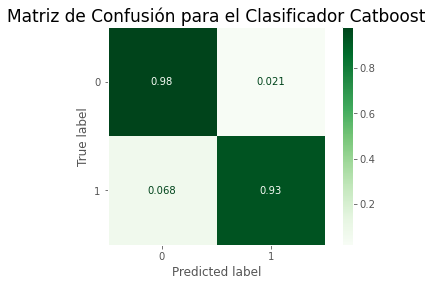

__________________________________________________________________


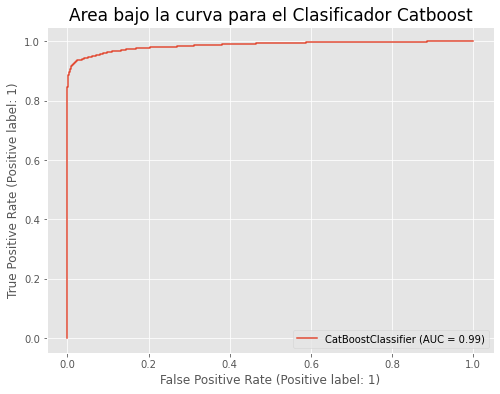

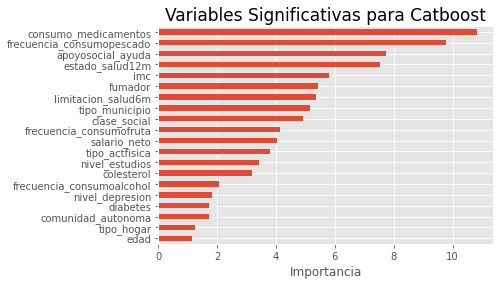

In [84]:
# Evaluación del modelo base
pf.evaluate_model(cat_base, X_train, X_test, y_test, 
               title='Catboost',tree=True)

In [85]:
# Clasificador aplicando GridSearch CV
# Estimadores a analizar
cat_params =  {'depth': [4,5,6,7,8,9,10],
               'learning_rate' : [.01,.02,.03,.04],
               'iterations'    : [10, 20,30,40,50,60,70,80,90,100]
               }

# Clasificador Base
cat_clf2 = CatBoostClassifier(random_state = rmst,
                              verbose = False)

# Evaluación y selección de estimadores
grid_cat = GridSearchCV(cat_clf2,
                        cat_params,
                        n_jobs=-1,
                        cv= crossval)

# Entrenamiento
cat_grid = grid_cat.fit(X_train, y_train,early_stopping_rounds=3,verbose=False)

In [86]:
# Mejores estimadores
cat_grid.best_params_

{'depth': 10, 'iterations': 100, 'learning_rate': 0.04}

In [87]:
# Estimadores a analizar
cat_params = {'depth': [2,4,6,8,10],
               'learning_rate' : [.02,.03,.04],
               'iterations'    : [10,50,100]
             }

# Clasificador con los mejores estimadores
cat_clf2 = CatBoostClassifier(random_state = rmst,
                              verbose = False)


# Evaluación y selección de estimadores
ggrid_cat = GridSearchCV(cat_clf2,
                         cat_params,
                         n_jobs=-1,
                         cv= crossval)

# Entrenamiento
cat_grid2 = grid_cat.fit(X_train, y_train,early_stopping_rounds=3,verbose=False)

In [88]:
# Mejores estimadores
cat_grid2.best_params_

{'depth': 10, 'iterations': 100, 'learning_rate': 0.04}

In [89]:
# Modelo XGboost con estimadores
cat_gridmodel = cat_grid2.best_estimator_
cat_gridmodel

__________________________________________________________________
Reporte para el Clasificador: 
	Catboost con GridSearchCV
__________________________________________________________________


              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3992
           1       0.96      0.94      0.95      3991

    accuracy                           0.95      7983
   macro avg       0.95      0.95      0.95      7983
weighted avg       0.95      0.95      0.95      7983

__________________________________________________________________


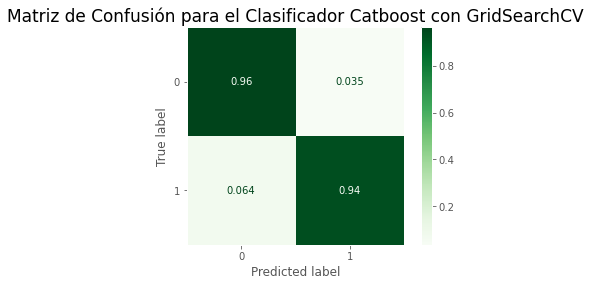

__________________________________________________________________


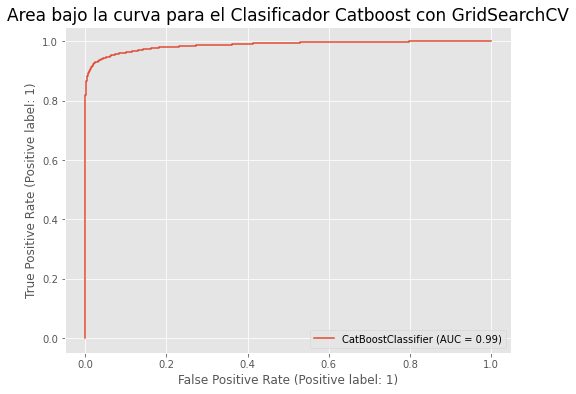

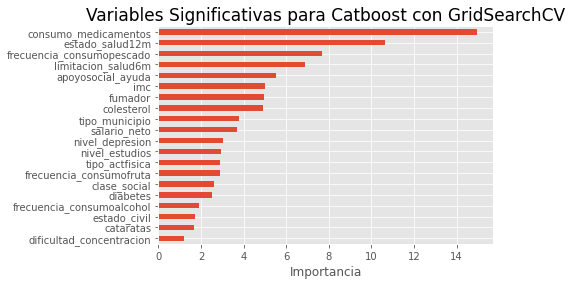

In [90]:
# Evaluación del modelo
pf.evaluate_model(cat_gridmodel, X_train, X_test, y_test, 
               title='Catboost con GridSearchCV', tree=True)

### 6.- Minería de Datos

Una vez ejecutados los 9 algoritmos de clasificación en su versión por defecto, y analizando su rendimiento con una parrilla de estimados, se debe escoger que estrategia tomar para la selección de un modelo definitivo que nos permita buscar patrones de predicción en la ansiedad y la depresión.

Para ello seleccionaremos los tres modelos que mejor rendimiento han ofrecido, tomando en cuenta los siguientes supuestos:

* __Mayor precisión__ en los valores del conjunto de datos correctamente clasificados…
* __Sensibilidad (recall)__ en la clasificación de cada clase; es importante tener en cuenta que un falso negativo puede ocasionar que un individuo presenta la enfermedad (1), pero que el modelo indique que no (0). Por ello este ratio debe ser el mas bajo posible.
* __Ratio alto en el AUC__, para asegurar que el modelo predice mas verdaderos positivos, que falsos positivos.

#### 6.1- Comparación de métricas

In [91]:
clasificador = {"Regresión Logística":logreg_clf,
                "Regresión Logística Grid":logreg_grid2,
                "Arbol de Decisión": tree_clf,
                "Arbol de Decisión Grid ": tree_grid2,
                "Random Forest": forest_clf,
                "Random Forest Grid": forest_grid2,
                "SVM": svm_clf,
                "SVM Grid": svm_grid2,
                "Naive Bayes": gnb_clf,
                "Naive Bayes Grid": nb_grid2,
                "Xgboost": xgb_clf,
                "Xgboost Grid": xgb_grid2,
                "CatBoost": cat_clf,
                "CatBoost Grid": cat_grid2,
                "Extra Trees": extratrees_clf,
                "Extra Trees Grid": extratrees_grid2,
                "SGD": sgd_clf,
                "SGD Grid": sgd_grid2
               }

In [92]:
#Precisión
from sklearn.metrics import accuracy_score

for nombre,clasf in clasificador.items():
    accuracy_clf= accuracy_score(y_true = y_test,
                                 y_pred = clasf.predict(X_test)
                                )

    acc_test = round(accuracy_clf,3)
    print("La precisión para el Modelo - %s" % nombre, "es: %s" %acc_test)

La precisión para el Modelo - Regresión Logística es: 0.799
La precisión para el Modelo - Regresión Logística Grid es: 0.799
La precisión para el Modelo - Arbol de Decisión es: 0.921
La precisión para el Modelo - Arbol de Decisión Grid  es: 0.844
La precisión para el Modelo - Random Forest es: 0.959
La precisión para el Modelo - Random Forest Grid es: 0.959
La precisión para el Modelo - SVM es: 0.822
La precisión para el Modelo - SVM Grid es: 0.964
La precisión para el Modelo - Naive Bayes es: 0.767
La precisión para el Modelo - Naive Bayes Grid es: 0.767
La precisión para el Modelo - Xgboost es: 0.948
La precisión para el Modelo - Xgboost Grid es: 0.955
La precisión para el Modelo - CatBoost es: 0.956
La precisión para el Modelo - CatBoost Grid es: 0.95
La precisión para el Modelo - Extra Trees es: 0.975
La precisión para el Modelo - Extra Trees Grid es: 0.962
La precisión para el Modelo - SGD es: 0.796
La precisión para el Modelo - SGD Grid es: 0.801


In [93]:
#Recall
from sklearn.metrics import recall_score

for nombre,clasf in clasificador.items():
    recall_clf = recall_score(y_true = y_test,
                              y_pred = clasf.predict(X_test),
                              average = None
                             )
    clase0 = round(recall_clf[0],3)
    clase1 = round(recall_clf[1],3)
    
    print("El recall para el Modelo - %s" % nombre, "es:", "[0] %s" % clase0, "[1] %s" % clase1)

El recall para el Modelo - Regresión Logística es: [0] 0.818 [1] 0.78
El recall para el Modelo - Regresión Logística Grid es: [0] 0.818 [1] 0.78
El recall para el Modelo - Arbol de Decisión es: [0] 0.915 [1] 0.926
El recall para el Modelo - Arbol de Decisión Grid  es: [0] 0.823 [1] 0.866
El recall para el Modelo - Random Forest es: [0] 0.969 [1] 0.948
El recall para el Modelo - Random Forest Grid es: [0] 0.969 [1] 0.948
El recall para el Modelo - SVM es: [0] 0.853 [1] 0.791
El recall para el Modelo - SVM Grid es: [0] 0.937 [1] 0.991
El recall para el Modelo - Naive Bayes es: [0] 0.79 [1] 0.744
El recall para el Modelo - Naive Bayes Grid es: [0] 0.79 [1] 0.744
El recall para el Modelo - Xgboost es: [0] 0.963 [1] 0.933
El recall para el Modelo - Xgboost Grid es: [0] 0.975 [1] 0.934
El recall para el Modelo - CatBoost es: [0] 0.979 [1] 0.932
El recall para el Modelo - CatBoost Grid es: [0] 0.965 [1] 0.936
El recall para el Modelo - Extra Trees es: [0] 0.959 [1] 0.99
El recall para el Mode

#### 6.2- Evaluación del modelo final

Como se puede observar en las gráficas y valores anteriores, hay cuatro modelos que no aportan la precisión ni la sensibilidad adecuada para la detección de este tipo de enfermedades; ellos son: Regresión Logística, Arboles de Decisión, Naive Bayes y SGD.

Pero por otro lado los algoritmos basados en conjunto de modelos (ensembles) y Support Vector Machine, si ofrecen unas métricas adecuadas al objetivo del estudio.

De hecho, los algoritmos SVM y XgBoost mejoran notablemente con la selección adecuada de estimadores.

De todos estos, el que mejor rendimiento presentó fue el clasificador Extra Tree. Por lo que para tomar una desición final; vamos a construir un stack de clasificadores con Random Forest, SVM y Xgboost y comparamos si en conjunto mejoran las métricas del Extra Tree.


In [94]:
estimators_grid = [
                    ('forest', forest_gridmodel),
                    ('svm', svm_gridmodel),
                    ('xgboost', xgb_gridmodel),  
                  ]
estimators_grid

[('forest', RandomForestClassifier(random_state=123)),
 ('svm', NuSVC(nu=0.125, random_state=123)),
 ('xgboost',
  XGBClassifier(max_depth=10, n_jobs=-1, random_state=123, subsample=0.3))]

In [95]:
# Cración del clasificador stack
stack_grid = StackingClassifier(estimators=estimators_grid, 
                                n_jobs=-1, 
                                passthrough=True,
                                final_estimator=LogisticRegression(random_state=rmst, n_jobs=-1))
stack_grid

StackingClassifier(estimators=[('forest',
                                RandomForestClassifier(random_state=123)),
                               ('svm', NuSVC(nu=0.125, random_state=123)),
                               ('xgboost',
                                XGBClassifier(max_depth=10, n_jobs=-1,
                                              random_state=123,
                                              subsample=0.3))],
                   final_estimator=LogisticRegression(n_jobs=-1,
                                                      random_state=123),
                   n_jobs=-1, passthrough=True)

In [96]:
# Entrenamiento del modelo stack
stackgrid_model = stack_grid.fit(X_train, y_train)

__________________________________________________________________
Reporte para el Clasificador: 
	Stacked Model
__________________________________________________________________


              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3992
           1       0.98      0.97      0.98      3991

    accuracy                           0.98      7983
   macro avg       0.98      0.98      0.98      7983
weighted avg       0.98      0.98      0.98      7983

__________________________________________________________________


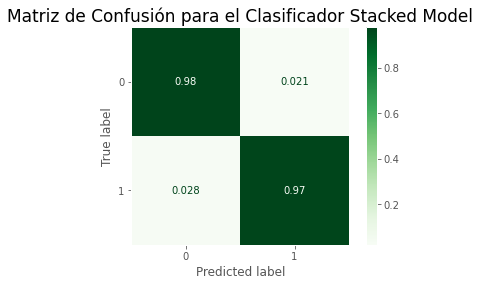

__________________________________________________________________


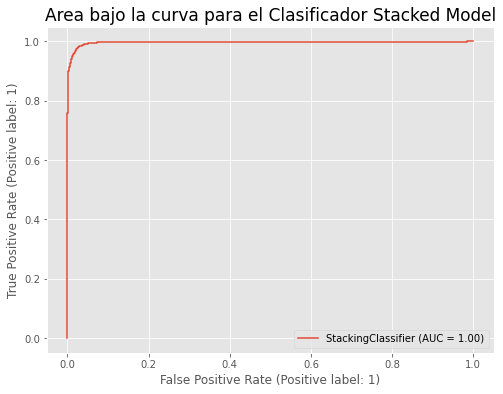

In [97]:
# Evaluación del modelo stack
pf.evaluate_model(stackgrid_model, X_train, X_test, y_test, 
               title='Stacked Model')

In [98]:
#Matriz de confusión del Stack
y_pred = extratrees_gridmodel.predict(X_test)
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

Confusion matrix:
 [[3746  246]
 [  54 3937]]


In [99]:
#Matriz de confusión del Stack
y_pred = stackgrid_model.predict(X_test)
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

Confusion matrix:
 [[3907   85]
 [ 110 3881]]


Como se puede observar el rendimiento y resultado de las métricas entre el Stack Classifier y el Extra Tree Classifier son mínimas, por lo que podemos considerar que ambas aproximaciones son correctas.

Pero si ilustramos el número de casos que se han clasificado como falsos negativos, un dato muy sensible a la valoración de enfermedades, nos decantamos por usar el __Modelo Simple con Clasificador Extra Tree__.

A nivel de velocidad de convergencia, el Extra Tree de por sí es un método más rápido que el usar estimadores en stack, algo a considerar en trabajos futuros si se añaden conjunto de datos con mayor número de instancias.

Dicho esto, esta es la evaluación del modelo escogido:

__________________________________________________________________
Reporte para el Clasificador: 
	Extra Trees con GridSearch CV
__________________________________________________________________


              precision    recall  f1-score   support

           0       0.99      0.94      0.96      3992
           1       0.94      0.99      0.96      3991

    accuracy                           0.96      7983
   macro avg       0.96      0.96      0.96      7983
weighted avg       0.96      0.96      0.96      7983

__________________________________________________________________


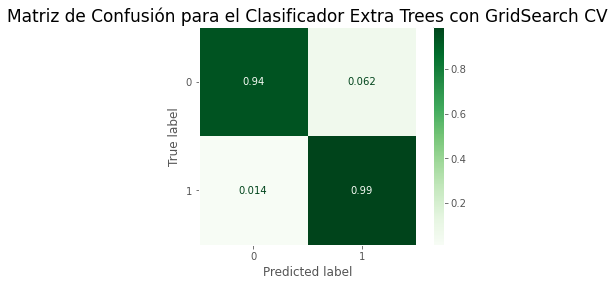

__________________________________________________________________


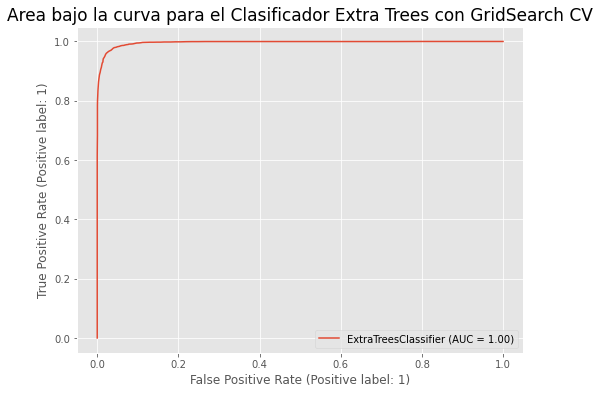

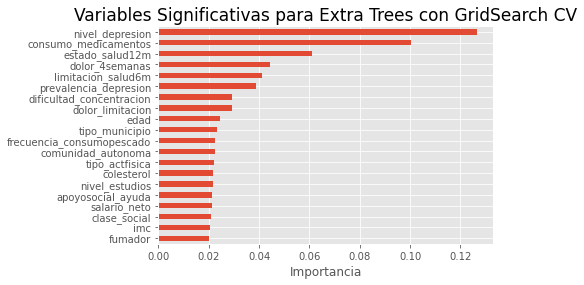

In [100]:
# Evaluación del modelo
pf.evaluate_model(extratrees_gridmodel, X_train, X_test, y_test, 
               tree=True, title='Extra Trees con GridSearch CV')

Con el uso de la herramienta PowerBI, se ilustrarán las tendencias de la variables significativas del modelo y su relación con la ansiedad y al depresión.

In [101]:
fin = datetime.now()
print("Fecha y hora de inicio =", inicio)
print("Fecha y hora de finalización =", fin)

Fecha y hora de inicio = 2022-09-28 13:51:04.716965
Fecha y hora de finalización = 2022-09-28 15:30:04.168873
